In [1]:
# -*- coding: utf-8 -*-

'''
This script is a local version of the Secondary_PneumoniaModel.py (originally created using Colab) 
and leverages the PyTorch libraries to build a model based on CNN architecture for pneumonia detection. 
It is designed with a modular structure that includes dropouts and batch normalisation to help reduce overfitting as much as possible. 
The training process uses the Adam optimiser and includes tools like early stopping, learning rate scheduling, 
and KFold cross-validation for better performance evaluation.
There is also a focus on data preprocessing and augmentation to improve generalisation.
'''

import os
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision import datasets
import torchvision.transforms.v2 as transforms

# Added parent directory to path for custom utils
sys.path.append("../")
import Utils.TorchUtils as Utils

device = Utils.get_device()
print(f"Found Device: {device}")


Found Device: mps


In [3]:
import requests
import zipfile
import pathlib

DATASET_LOCATION = pathlib.Path('chest_xray')

DATASET_LOCATION.mkdir(parents=True, exist_ok=True)

url = 'https://www.kaggle.com/api/v1/datasets/download/paultimothymooney/chest-xray-pneumonia'
zip_path = pathlib.Path('~/Downloads/chest-xray-pneumonia.zip').expanduser()


zip_path.parent.mkdir(parents=True, exist_ok=True)

response = requests.get(url, stream=True)
with open(zip_path, 'wb') as file:
    for chunk in response.iter_content(chunk_size=128):
        file.write(chunk)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(DATASET_LOCATION)

print(f"Dataset location: {DATASET_LOCATION}")

Dataset location: chest_xray


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Constants
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_CHANNELS = 1
BATCH_SIZE = 32

# Constants for dropout rates
DROPOUT_RATE_2D = 0.4
DROPOUT_RATE_1D = 0.6

class PneumoniaDetectionModel(nn.Module):
    def __init__(self):
        super(PneumoniaDetectionModel, self).__init__()

        # Feature extraction layers
        self.features = nn.Sequential(
            nn.Conv2d(IMAGE_CHANNELS, 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(inplace=True),
            nn.Dropout2d(DROPOUT_RATE_2D),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Dropout2d(DROPOUT_RATE_2D),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Dropout2d(DROPOUT_RATE_2D),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Dropout2d(DROPOUT_RATE_2D),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout2d(DROPOUT_RATE_2D),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # Classification layers
        self.classifier = nn.Sequential(
            nn.Dropout(DROPOUT_RATE_1D),
            nn.Linear(128 * 7 * 7, 512),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(512),
            nn.Dropout(DROPOUT_RATE_1D),

            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(256),
            nn.Dropout(DROPOUT_RATE_1D),

            nn.Linear(256, 2)
        )

        self.initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

model = PneumoniaDetectionModel()
print(model)

PneumoniaDetectionModel(
  (features): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout2d(p=0.4, inplace=False)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): Dropout2d(p=0.4, inplace=False)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): Dropout2d(p=0.4, inplace=False)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fals

In [5]:
from sklearn.model_selection import KFold

class PneumoniaTrainer:
    def __init__(self, model, data_dir, device=None, batch_size=BATCH_SIZE):
        self.data_dir = data_dir
        self.device = device
        self.model = model.to(self.device)
        self.batch_size = batch_size

        self.train_transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=IMAGE_CHANNELS),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.RandomResizedCrop((IMAGE_WIDTH, IMAGE_HEIGHT), scale=(.8, 1), ratio=(0.70, 1.40)),
            transforms.ColorJitter(brightness=.3, contrast=.5, saturation=.5, hue=.1),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])

        self.val_transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=IMAGE_CHANNELS),
            transforms.Resize((IMAGE_WIDTH, IMAGE_HEIGHT)),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])

        self.prepare_data()

        self.full_dataset = datasets.ImageFolder(
            os.path.join(self.data_dir, DATASET_LOCATION, 'train'), 
            transform=self.train_transform
        )
        
        train_size = int(0.8 * len(self.full_dataset))
        val_size = len(self.full_dataset) - train_size
        train_dataset, val_dataset = random_split(
            self.full_dataset, 
            [train_size, val_size]
        )
        
        val_dataset.dataset.transform = self.val_transform
        
        self.train_loader = DataLoader(
            train_dataset, 
            batch_size=self.batch_size, 
            shuffle=True
        )
        self.val_loader = DataLoader(
            val_dataset, 
            batch_size=self.batch_size, 
            shuffle=False
        )

    def prepare_data(self):
        self.full_dataset = datasets.ImageFolder(os.path.join(self.data_dir, DATASET_LOCATION, 'train'), transform=self.train_transform)

    def train(self, epochs=20, learning_rate=0.001):
        loss_function = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3)

        best_val_acc = 0
        patience = 7
        patience_counter = 0

        for epoch in range(epochs):
            # Training phase
            self.model.train()
            running_loss = 0.0
            correct = 0
            total = 0

            for inputs, labels in self.train_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = loss_function(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

            train_loss = running_loss / len(self.train_loader)
            train_acc = 100. * correct / total

            # Validation phase
            val_loss, val_acc = self.validate(loss_function)

            print(f'Epoch [{epoch+1}/{epochs}]')
            print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
            print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
            print(f'Best Val Acc: {best_val_acc:.2f}%')

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter > patience:
                print('Early stopping triggered')
                break
        
            scheduler.step(val_loss)

    def validate(self, loss_function):
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in self.val_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                loss = loss_function(outputs, labels)

                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_loss = running_loss / len(self.val_loader)
        val_acc = 100. * correct / total
        return val_loss, val_acc

    def cross_validate(self, k=5, epochs=20, learning_rate=0.001):
        kf = KFold(n_splits=k, shuffle=True)
        fold_results = []

        for fold, (train_idx, val_idx) in enumerate(kf.split(self.full_dataset)):
            print(f'Fold {fold+1}/{k}')
            train_subset = torch.utils.data.Subset(self.full_dataset, train_idx)
            val_subset = torch.utils.data.Subset(self.full_dataset, val_idx)
            val_subset.dataset.transform = self.val_transform

            self.train_loader = DataLoader(train_subset, batch_size=self.batch_size, shuffle=True, num_workers=2)
            self.val_loader = DataLoader(val_subset, batch_size=self.batch_size, shuffle=False, num_workers=2)

            self.model.apply(self.reset_weights)  # Reset model weights for each fold
            self.train(epochs=epochs, learning_rate=learning_rate)
            val_loss, val_acc = self.validate(nn.CrossEntropyLoss())
            fold_results.append((val_loss, val_acc))

        avg_val_loss = sum([result[0] for result in fold_results]) / k
        avg_val_acc = sum([result[1] for result in fold_results]) / k
        print(f'Average Validation Loss: {avg_val_loss:.4f}, Average Validation Accuracy: {avg_val_acc:.2f}%')

    def reset_weights(self, m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            m.reset_parameters()


In [6]:
DATASET_LOCATION = 'chest_xray'

model = PneumoniaDetectionModel()
trainer = PneumoniaTrainer(model, DATASET_LOCATION, device=device)
best_val_acc = trainer.train(epochs=20, learning_rate=0.001)

/Users/lapusanrv/.pyenv/versions/3.12.4/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Epoch [1/20]
Train Loss: 0.4904, Train Acc: 78.93%
Val Loss: 0.3419, Val Acc: 84.29%
Best Val Acc: 0.00%
Epoch [2/20]
Train Loss: 0.3581, Train Acc: 86.17%
Val Loss: 0.2180, Val Acc: 92.15%
Best Val Acc: 84.29%
Epoch [3/20]
Train Loss: 0.3132, Train Acc: 88.18%
Val Loss: 0.2686, Val Acc: 89.75%
Best Val Acc: 92.15%
Epoch [4/20]
Train Loss: 0.2914, Train Acc: 88.64%
Val Loss: 0.1798, Val Acc: 94.06%
Best Val Acc: 92.15%
Epoch [5/20]
Train Loss: 0.2489, Train Acc: 90.46%
Val Loss: 0.1435, Val Acc: 94.64%
Best Val Acc: 94.06%
Epoch [6/20]
Train Loss: 0.2313, Train Acc: 90.53%
Val Loss: 0.1200, Val Acc: 95.59%
Best Val Acc: 94.64%
Epoch [7/20]
Train Loss: 0.2056, Train Acc: 91.54%
Val Loss: 0.1434, Val Acc: 94.83%
Best Val Acc: 95.59%
Epoch [8/20]
Train Loss: 0.2089, Train Acc: 91.80%
Val Loss: 0.1183, Val Acc: 95.59%
Best Val Acc: 95.59%
Epoch [9/20]
Train Loss: 0.1990, Train Acc: 92.14%
Val Loss: 0.1212, Val Acc: 95.40%
Best Val Acc: 95.59%
Epoch [10/20]
Train Loss: 0.1874, Train Acc: 92

In [7]:
# Saving the model's weights
model_save_path = 'pneumonia_detection_model.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to pneumonia_detection_model.pth


/Users/lapusanrv/.pyenv/versions/3.12.4/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Testing Pneumonia Detection Model
Using device: mps
Results Summary: Overall Accuracy: 73.56% | Average Batch Accuracy: 73.56% | Total Correct: 459/624


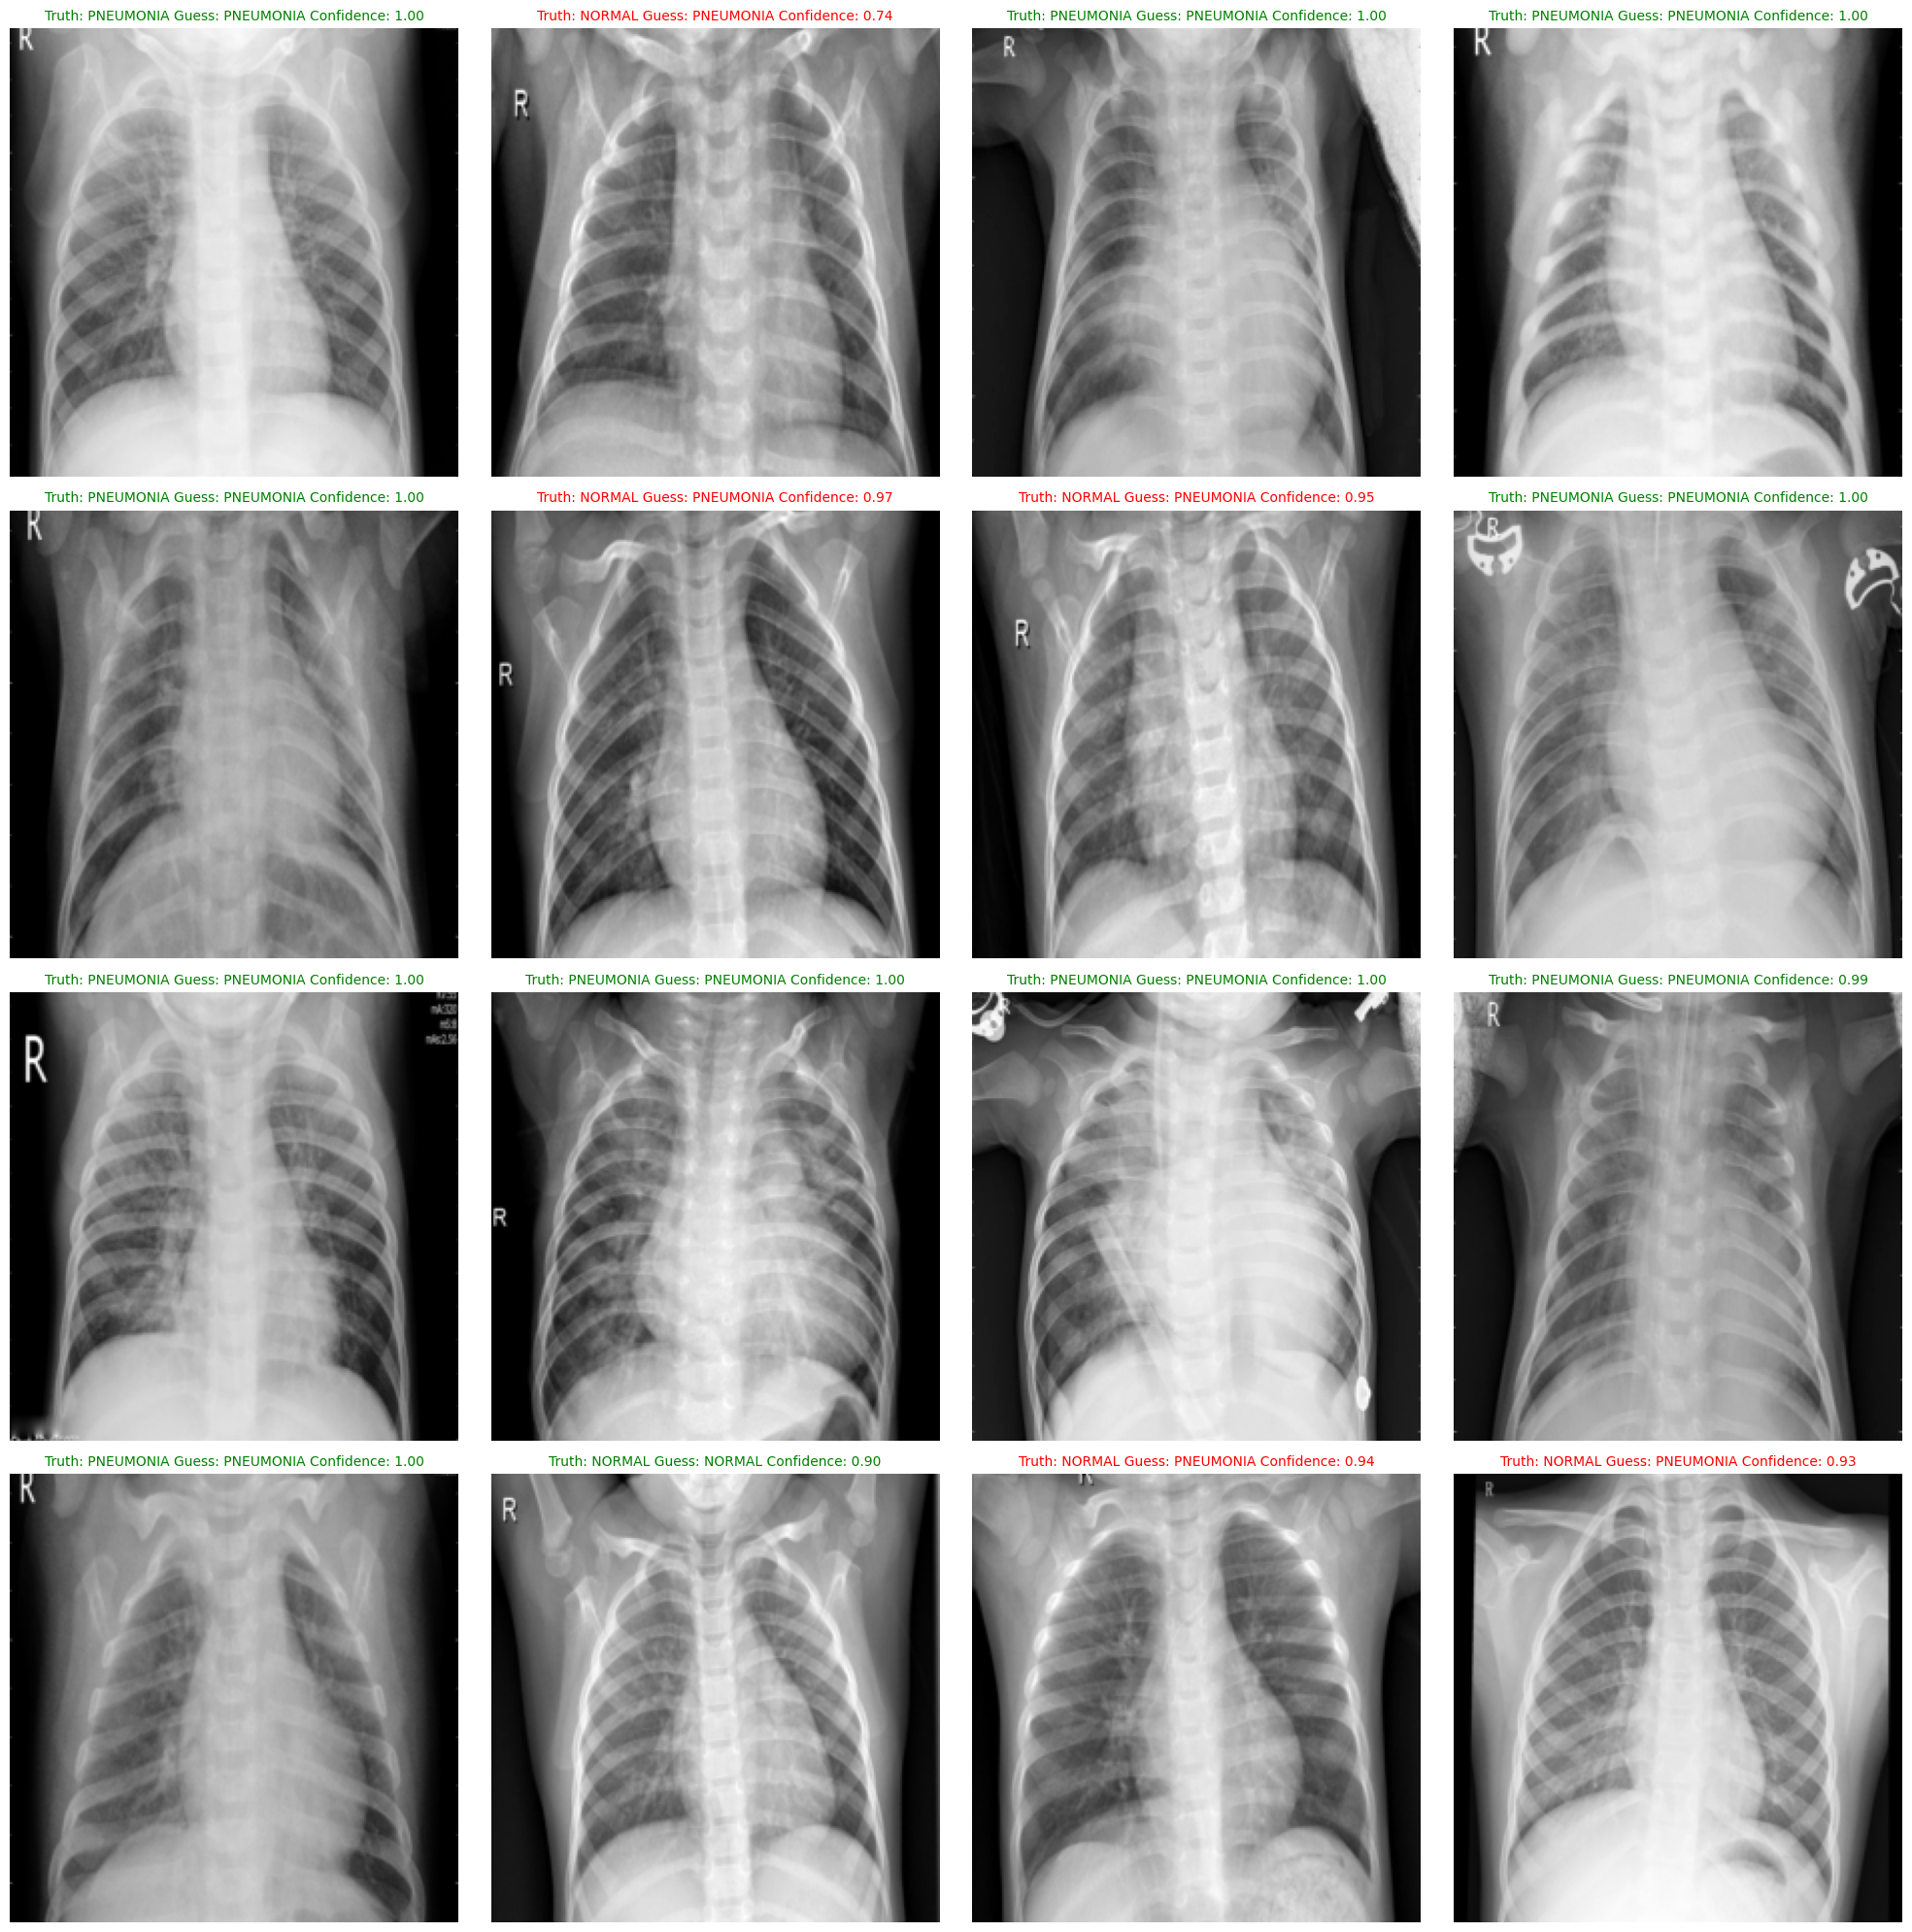

Performance Comparison:
Best Validation Accuracy: 96.36%
Test Accuracy: 73.56%


In [10]:
class ModelTester:
    def __init__(self, model, device):
        self.model = model.to(device)
        self.device = device
        self.image_transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])

    def test_model(self, test_folder, batch_size=16):
        if not os.path.exists(test_folder):
            raise FileNotFoundError(f"Test folder {test_folder} does not exist.")

        test_data = datasets.ImageFolder(test_folder, transform=self.image_transform)
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, pin_memory=True)

        total_correct = 0
        total_images = 0
        batch_accuracies = []

        self.model.eval()
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)
                _, predictions = torch.max(outputs, 1)
                correct = (predictions == labels).sum().item()
                batch_accuracy = (correct / labels.size(0)) * 100
                batch_accuracies.append(batch_accuracy)
                total_correct += correct
                total_images += labels.size(0)

        final_accuracy = (total_correct / total_images) * 100
        avg_batch_accuracy = sum(batch_accuracies) / len(batch_accuracies)

        print(f"Results Summary: Overall Accuracy: {final_accuracy:.2f}% | "
              f"Average Batch Accuracy: {avg_batch_accuracy:.2f}% | "
              f"Total Correct: {total_correct}/{total_images}")
        return final_accuracy

    def show_example_predictions(self, test_folder, num_images=16):
        if not os.path.exists(test_folder):
            raise FileNotFoundError(f"Test folder {test_folder} does not exist.")

        test_data = datasets.ImageFolder(test_folder, transform=self.image_transform)
        loader = DataLoader(test_data, batch_size=num_images, shuffle=True)
        images, labels = next(iter(loader))
        images = images.to(self.device)

        self.model.eval()
        with torch.no_grad():
            outputs = self.model(images)
            probabilities = F.softmax(outputs, dim=1)
            predictions = torch.argmax(probabilities, dim=1)
            confidence = torch.max(probabilities, dim=1)[0]

        plt.figure(figsize=(20, 20))
        for i in range(num_images):
            plt.subplot(4, 4, i + 1)
            img = images[i].cpu().squeeze()
            plt.imshow(img, cmap='gray')
            true_label = test_data.classes[labels[i]]
            pred_label = test_data.classes[predictions[i]]
            conf = confidence[i].item()
            color = 'green' if predictions[i] == labels[i] else 'red'
            plt.title(f'Truth: {true_label} Guess: {pred_label} Confidence: {conf:.2f}', color=color, fontsize=10)
            plt.axis('off')

        plt.tight_layout()
        plt.show()

def test_model(model):
    device = Utils.get_device()
    tester = ModelTester(model, device)
    test_folder = 'chest_xray/chest_xray/test'

    print("Testing Pneumonia Detection Model")
    print(f"Using device: {device}")

    try:
        accuracy = tester.test_model(test_folder)
        tester.show_example_predictions(test_folder)
        print("Performance Comparison:")
        print("Best Validation Accuracy: 96.36%")
        print(f"Test Accuracy: {accuracy:.2f}%")
    except FileNotFoundError as e:
        print(e)
    except Exception as e:
        print(f"An error occurred: {e}")

test_model(model)